# Conway's Game of Life

In [1]:
from IPython.display import HTML
from life import random_grid, gosper_glider_gun_grid, step, matplotlib_animation

## Random Grid

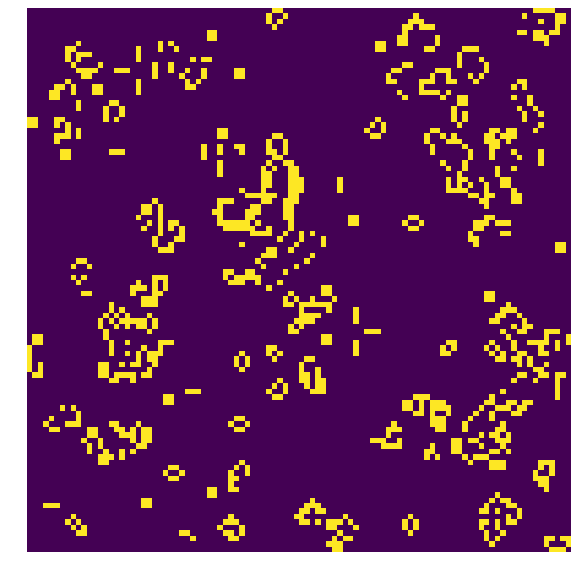

In [2]:
grid = random_grid(100)
anim = matplotlib_animation(grid)
HTML(anim.to_jshtml())

## Gosper Glider Gun

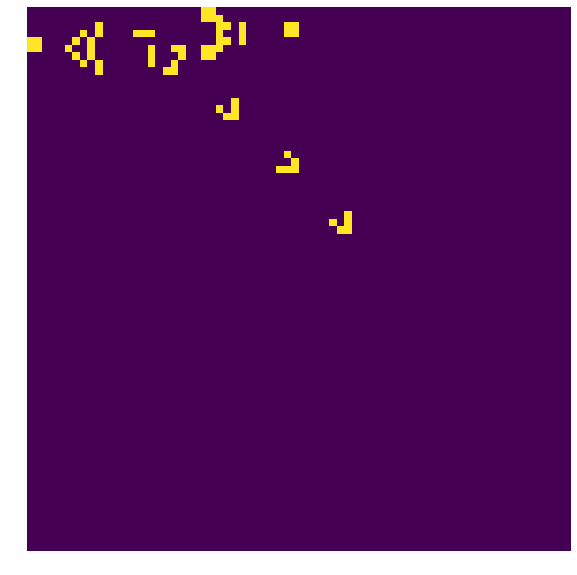

In [3]:
grid = gosper_glider_gun_grid()
anim = matplotlib_animation(grid)
HTML(anim.to_jshtml())

## Benchmarking

### Vanilla Python

In [4]:
n = 100
grid = random_grid(100)
%timeit step(grid)

10.3 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [5]:
def basic_run(grid, generations):
    for i in range(generations):
        grid = step(grid)

In [6]:
grid = random_grid(n)
%timeit basic_run(grid, 100)

940 ms ± 6.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Let's Cython Things!

In [7]:
%load_ext Cython

In [8]:
%%cython

cimport cython

import numpy as np
cimport numpy as np

from scipy.signal import convolve2d

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX
    
cdef int DEAD = 0
cdef int ALIVE = 1


@cython.boundscheck(False)
@cython.wraparound(False)
def cython_step(np.int64_t[:, :] grid):
    cdef int n = grid.shape[0]
    updated = grid.copy()
    
    # no cdefs in loops
    cdef int i, j, neighbours, state, old_state
    
    for i in range(n):
        for j in range(n):
            neighbours = 0

            if i != 0:
                # N
                if grid[i - 1][j] == ALIVE:
                    neighbours += 1

                # NE
                if j != n - 1 and grid[i - 1][j + 1] == ALIVE:
                    neighbours += 1

            if j != n - 1:
                # E
                if grid[i][j + 1] == ALIVE:
                    neighbours += 1

                # SE
                if i != n - 1 and grid[i + 1][j + 1] == ALIVE:
                    neighbours += 1

            if i != n - 1:
                # S
                if grid[i + 1][j] == ALIVE:
                    neighbours += 1

                # SW
                if j != 0 and grid[i + 1][j - 1] == ALIVE:
                    neighbours += 1

            if j != 0:
                # W
                if grid[i][j - 1] == ALIVE:
                    neighbours += 1

                # SW
                if i != 0 and grid[i - 1][j - 1] == ALIVE:
                    neighbours += 1

            state = grid[i][j]
            old_state = state

            if state == DEAD:
                if neighbours == 3:
                    state = ALIVE
            elif state == ALIVE:
                if neighbours < 2 or neighbours > 3:
                    state = DEAD
                else:
                    state = ALIVE

            updated[i][j] = state
    
    return updated

@cython.boundscheck(False)
@cython.wraparound(False)
def cython_step_convolve(np.int64_t[:, :] grid):
    cdef int n = grid.shape[0]
    # TODO not completely sure I'm handling the boundary conditions exactly as I would like...
    nbrs_count = convolve2d(grid, np.ones((3, 3)), mode='same', boundary='symm') - grid
    return (nbrs_count == 3) | (grid & (nbrs_count == 2))

@cython.boundscheck(False)
@cython.wraparound(False)
def cython_run(np.int64_t[:, :] grid, int generations):
    cdef int i
    for i in range(generations):
        grid = cython_step(grid)

#### Does it still work?

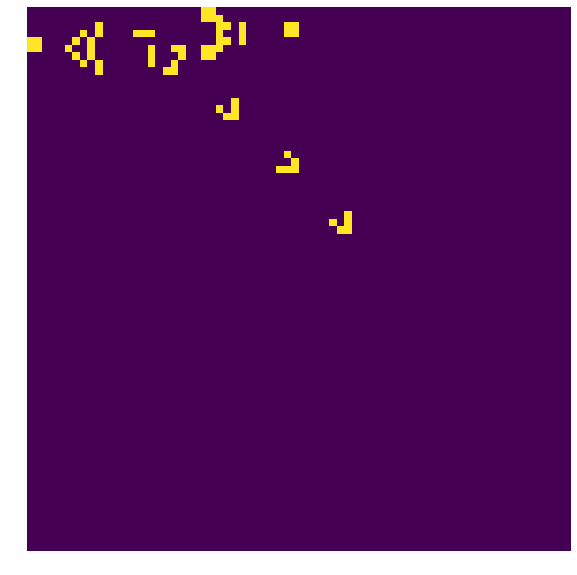

In [9]:
# hacky but we need this to now be a numpy array...
grid = np.array(gosper_glider_gun_grid())
anim = matplotlib_animation(grid, step_func=cython_step)
HTML(anim.to_jshtml())

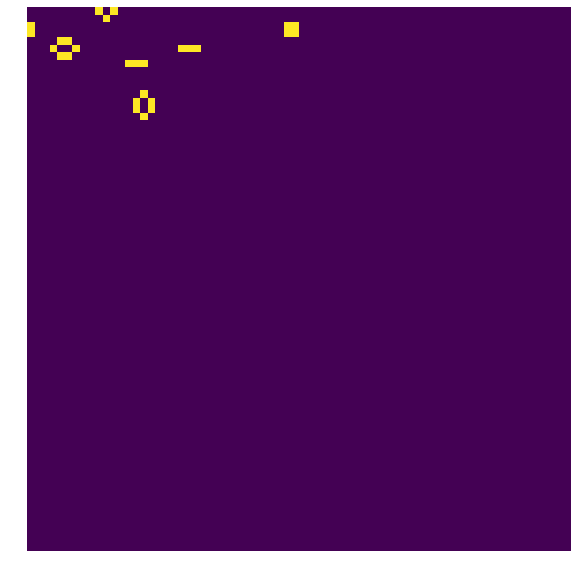

In [10]:
# hacky but we need this to now be a numpy array...
grid = np.array(gosper_glider_gun_grid())
anim = matplotlib_animation(grid, step_func=cython_step_convolve)
HTML(anim.to_jshtml())

In [11]:
grid = np.array(random_grid(100))
%timeit cython_run(grid, 100)

590 ms ± 7.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
n = 1000

In [13]:
grid = random_grid(n)
%timeit step(grid)

1.32 s ± 42.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
grid = np.array(random_grid(n))
%timeit cython_step(grid)

650 ms ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
grid = np.array(random_grid(n))
%timeit cython_step_convolve(grid)

51.2 ms ± 835 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


- Hmm, I should be getting much closer to the scipy convolve result I feel...Only a 2x speedup for the Cython makes it seem like I'm doing something wrong. Let's have another go...

In [16]:
%%cython

cimport cython

import numpy as np
cimport numpy as np

cdef int DEAD = 0
cdef int ALIVE = 1

@cython.boundscheck(False)
@cython.wraparound(False)
cdef void _cython_update(np.int64_t[:, :] grid, int n, int i, int j, np.int64_t[:, :] updated):
    cdef int neighbours, state, old_state
    neighbours = 0

    if i != 0:
        # N
        if grid[i - 1][j] == ALIVE:
            neighbours += 1

        # NE
        if j != n - 1 and grid[i - 1][j + 1] == ALIVE:
            neighbours += 1

    if j != n - 1:
        # E
        if grid[i][j + 1] == ALIVE:
            neighbours += 1

        # SE
        if i != n - 1 and grid[i + 1][j + 1] == ALIVE:
            neighbours += 1

    if i != n - 1:
        # S
        if grid[i + 1][j] == ALIVE:
            neighbours += 1

        # SW
        if j != 0 and grid[i + 1][j - 1] == ALIVE:
            neighbours += 1

    if j != 0:
        # W
        if grid[i][j - 1] == ALIVE:
            neighbours += 1

        # SW
        if i != 0 and grid[i - 1][j - 1] == ALIVE:
            neighbours += 1

    state = grid[i][j]
    old_state = state

    if state == DEAD:
        if neighbours == 3:
            state = ALIVE
    elif state == ALIVE:
        if neighbours < 2 or neighbours > 3:
            state = DEAD
        else:
            state = ALIVE

    updated[i][j] = state


@cython.boundscheck(False)
@cython.wraparound(False)
def cython_step2(np.int64_t[:, :] grid):
    cdef int n = grid.shape[0]
    updated = grid.copy()
    
    # no cdefs in loops
    cdef int i, j
    
    for i in range(n):
        for j in range(n):
            _cython_update(grid, n, i, j, updated)
    
    return updated

In [17]:
grid = np.array(random_grid(n))
%timeit cython_step2(grid)

55.4 ms ± 372 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


- Ahhh! Much closer to the scipy result!